In [138]:
from guide import *
from pprint import pprint
import numpy as np
import re

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Part A: Database access

In [112]:
# Exercise 1
myprotein = getSequence('TMM25_HUMAN', format='txt')
mysequence = getSequence('TMM25_HUMAN', format='fasta')
header = myprotein.split('\n', 1)[0]
print("Currently processing the sequence with name UNIPROT: %s" % header.split()[1])
sp_end = None
for line in myprotein.splitlines():
    words = line.split()
    if words[0] == 'FT' and words[1] == 'SIGNAL':
        sp_end = (words[2].split(".."))[1]
if sp_end != None:
    print("There is a signal peptide ending at position %d" % int(sp_end))
    print("The signal peptide looks like this: %s" % mysequence.sequence[:int(sp_end)])
else:
    print("There is no signal peptide")

Currently processing the sequence with name UNIPROT: TMM25_HUMAN
There is a signal peptide ending at position 26
The signal peptide looks like this: MALPPGPAALRHTLLLLPALLSSGWG


In [114]:
# Exercise 2

# This code looks for proteins in the DAO family of enzymes from the Uniprot database
# that are annotated as being from E. coli. It then writes those sequences to a file
# called 'dao.fa' in FASTA format. It also prints the number of sequences that it finds
# in E. coli.

names = searchSequences('family:DAO AND reviewed:true')
cnt = 0
seqs = []
for name in names:
    seq = getSequence(name)
    seqs.append(seq)
    start_index = seq.annot.find("OS=")
    if start_index != -1:
        end_index = seq.annot.find("=", start_index + 3)
        if end_index == -1:
            end_index = len(seq.annot)
        species = seq.annot[start_index + 3:end_index]
        print(seq.name, '\t', species)
        if species.startswith("Escherichia coli"):
            print('*')
            cnt += 1
    else:
        print(seq.name, '\t no species')
writeFastaFile('dao.fa', seqs)
if cnt > 0:
    print("Found %d exemplars in E. coli" % cnt)

sp|O31616|GLYOX_BACSU 	 Bacillus subtilis (strain 168) OX
sp|P77182|MNMC_ECOLI 	 Escherichia coli (strain K12) OX
*
sp|Q5L2C2|GLYOX_GEOKA 	 Geobacillus kaustophilus (strain HTA426) OX
sp|Q88Q83|GLYOX_PSEPK 	 Pseudomonas putida (strain ATCC 47054 / DSM 6125 / CFBP 8728 / NCIMB 11950 / KT2440) OX
sp|S5FMM4|GLYOX_BACLI 	 Bacillus licheniformis OX
sp|Q3M859|THIOG_TRIV2 	 Trichormus variabilis (strain ATCC 29413 / PCC 7937) OX
sp|Q55710|THIOG_SYNY3 	 Synechocystis sp. (strain PCC 6803 / Kazusa) OX
sp|Q8YRC9|THIOG_NOSS1 	 Nostoc sp. (strain PCC 7120 / SAG 25.82 / UTEX 2576) OX
sp|Q9HUH4|Y4991_PSEAE 	 Pseudomonas aeruginosa (strain ATCC 15692 / DSM 22644 / CIP 104116 / JCM 14847 / LMG 12228 / 1C / PRS 101 / PAO1) OX
sp|A0K2U3|MNMC_BURCH 	 Burkholderia cenocepacia (strain HI2424) OX
sp|A0KJJ9|MNMC_AERHH 	 Aeromonas hydrophila subsp. hydrophila (strain ATCC 7966 / DSM 30187 / BCRC 13018 / CCUG 14551 / JCM 1027 / KCTC 2358 / NCIMB 9240 / NCTC 8049) OX
sp|A0KV89|MNMC_SHESA 	 Shewanella sp. (strai

In [ ]:
# Exercise 3
# Fasta files are a file format for storing sequence data
# Reading the fail.fa file fails because the second sequence in the file has a space in front of the ">" symbol and the code considers that to be apart of the first sequence.
# Since ">" symbols are illegal in protein alphabets, a runtime error is raised and the fasta file is not read
readFastaFile('fail.fa',Protein_Alphabet)

# Part b: Sequence alignment

In [117]:
b62 = readSubstMatrix("blosum62.matrix",Protein_Alphabet)
seqs = readFastaFile('dao.fa',Protein_Alphabet)

In [115]:
my_student_number = 47850385 # replace this number with your UQ student number
my_sequence_number = my_student_number % (len(seqs) - 1)
print('I will be using sequence number %d, which is %s' % (my_sequence_number, seqs[my_sequence_number].name))

I will be using sequence number 77, which is sp|B0SVF8|MNMC_CAUSK


In [118]:
# Exercise 4

best1 = 0
idx1 = 0
best2 = 0
idx2 = 0

for idx in range(len(seqs)): # iterate over all sequences

    # If the sequence is not the same as the sequence we are comparing to
    if idx != my_sequence_number:
        seq = seqs[idx] # Get the sequence at the current index
        aln = align(seqs[my_sequence_number], seq, b62, -7) # Align the sequences
        percent = scoreAlignment(aln) / aln.alignlen # Calculate the percentage of the alignment (how similar they are)

        if best1 < percent: # Keeping track of the best and second best scores 
            best2 = best1 # Save the current best score as the second best score
            idx2 = idx1
            best1 = percent # Save the current score as the best score
            idx1 = idx
        elif best2 < percent: # Keeping track of the second best score 
            best2 = percent #  Save the current score as the second best score
            idx2 = idx


print('The best match is %s with %f%%' % (seqs[idx1].name, best1 * 100))
print('The second best match is %s with %f%%' % (seqs[idx2].name, best2 * 100))

The best match is sp|Q9AA58|MNMC_CAUVC with 67.218543%
The second best match is sp|Q0ALP0|MNMC_MARMM with 42.673108%


In [119]:
# Exercise 5
def getConsensusForColumn(aln, colidx):
    symcnt = {}

    for seq in aln.seqs:
        mysym = seq[colidx]
        if mysym in symcnt:
            symcnt[mysym] += 1
        else:
            symcnt[mysym] = 1
    consensus = None
    maxcnt = 0
    for mysym in symcnt:
        if symcnt[mysym] > maxcnt:
            maxcnt = symcnt[mysym]
            consensus = mysym
    return consensus

# This function takes an alignment and returns the consensus sequence
def getConsensus(aln):
    consensus_str = '' # The consensus string
    for colidx in range(aln.alignlen): # Iterate over all columns in the alignment
        consensus_str += getConsensusForColumn(aln, colidx) # Get the consensus residue for each column and append it to a string
    return Sequence(consensus_str, Protein_Alphabet, name='Consensus', gappy=True) # Return the consensus sequence


aln = readClustalFile('dao.aln',Protein_Alphabet)
consensus = getConsensus(aln)
print(consensus.sequence)

--------------------SIQPATL----EWNE---D----GTPVSRQFDDVYFSNDNGLEETRYVFLGGNGLPERWAEH-----------RLFVIAETGFGTGLNFLALWQAFRQFRPA-------------------------LQRLHFISFEKFPLTRADLARAHQ------------------------HW---------P----ELAP---LAEQLLAQWP---A-LL----PGCHRLLFDEGRVTLDLWFGDINELLPQ--------------------LNARVDAWFLDGFAPAKNPD-------MWTP-------------------------NL------FNAMARLARPGATLATF-----TSAGFV------------R--RGLQEAGFTVQKVK-----------------------GFGRKREMLCGEMEQRL-------------------------PWF-RP-----------------------KRDAAIIGGGIAGAALALALARRGWQVTLYCADEAP-AQGASGNPQGALYPLLSKDDNALSRFFRAAFLFARRFYDALL--------------G-AFDHDWCGVLQLAWDEKSAERLAKML---ALGLPA-----------ELASALDAEEAEQL---AGLPLACGGLFYPQGGWLCPAELTRALLALA----G---TLHYGTEVQRL--ER------------------D-GW----------------------QLLDAQG-------------------ASAPVVVLA--NGHQITRFS-------------QTAHLP----LYPVRGQVSHIPTT--------------PAL--LKT-VLCYDGYLTPA-----------------NG--HHC-----IGASYDRGDED-----TAFREADQQ----ENLQRLQECLPD--------W-------------------------------------------EVD

In [120]:
aln = readClustalFile('dao.aln', Protein_Alphabet)
my_favourites = ["sp|Q9AA58|MNMC_CAUVC", "sp|Q0ALP0|MNMC_MARMM", "sp|B0SVF8|MNMC_CAUSK", "sp|A1JKL6|MNMC_YERE8", "sp|A5IC27|MNMC_LEGPC", "sp|C3LP59|MNMC_VIBCM", "sp|Q1C669|MNMC_YERPA", "sp|A1K5J4|MNMC_AZOSB", "sp|Q3SID4|MNMC_THIDA", "sp|Q04XS7|MNMC_LEPBL"]
selected_seqs = []
for seq in aln.seqs:
    for name in my_favourites:
        if seq.name == name:
            selected_seqs.append(seq)
            break
selected = Alignment(selected_seqs)

In [121]:
 # Exercise 6
def calcDistances(alignments, measure = 'fractional', a=1.0):
   
    measure = measure.lower()
    if not measure in ['fractional', 'poisson', 'gamma', 'jc', 'k2p']:
        raise RuntimeError('Unsupported evolutionary distance measure: %s' % measure)
    a = float(a)
    distmat = numpy.zeros((len(alignments.seqs), len(alignments.seqs)))
    # Loop through each pair of sequences
    for i in range(len(alignments.seqs)):
        for j in range(i + 1, len(alignments.seqs)):
            seqA = alignments.seqs[i]
            seqB = alignments.seqs[j]
            # Calculate the fractional distance (p) first
            # The two sequences of interest are in seqA and seqB
            L = 0
            D = 0
            for k in range(alignments.alignlen):
                # For every non-gapped column, put to L
                # For every non-gapped column where the sequences are
                # different, put to D
                if seqA[k] != '-' and seqB[k] != '-':
                    L += 1
                    if seqA[k] != seqB[k]:
                        D += 1
            p = D / L
            # Now calculate the specified measure based on p
            if measure == 'fractional':
                dist = p
            ### BEGIN SOLUTION ###
            elif measure == 'poisson':  
                dist = -math.log(1 - p) # Poisson distance 
            elif measure == 'gamma':
                dist = a * ((1-p)**(-1/a) - 1) # Gamma distance
            ### END SOLUTION ###
            else:
                raise RuntimeError('Not implemented: %s' % measure)
            distmat[i, j] = distmat[j, i] = dist
    return distmat

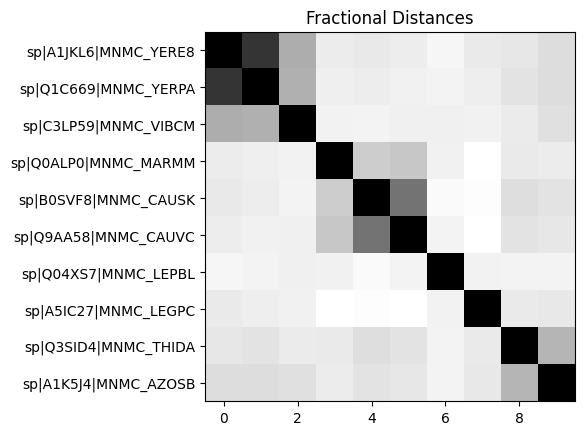

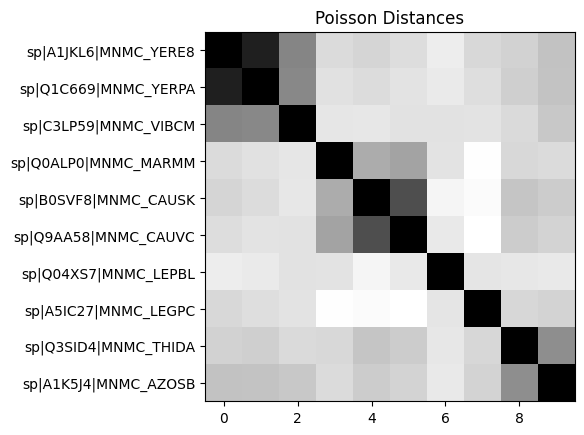

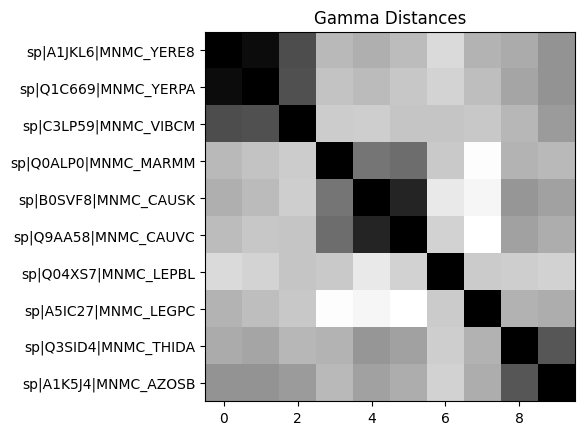

In [122]:
# Exercise 6
import numpy as np
import matplotlib.pyplot as plt
p_distance = calcDistances(selected,'fractional')
poisson_distance = calcDistances(selected,'poisson')
gamma_distance = calcDistances(selected,'gamma',a=0.7)

# Plot heat map for each distance matrix
fig, ax = plt.subplots()
ax.imshow(p_distance, plt.cm.gray, interpolation='nearest')
plt.yticks(np.arange(len(selected)), [s.name for s in selected])
plt.title('Fractional Distances')
plt.show()

fig, ax = plt.subplots()
ax.imshow(poisson_distance, plt.cm.gray, interpolation='nearest')
plt.yticks(np.arange(len(selected)), [s.name for s in selected])
plt.title('Poisson Distances')
plt.show()

fig, ax = plt.subplots()
ax.imshow(gamma_distance, plt.cm.gray, interpolation='nearest')
plt.yticks(np.arange(len(selected)), [s.name for s in selected])
plt.title('Gamma Distances')
plt.show()

In [124]:
import csv
yeasts = dict()
with open('sugars.csv', 'rt') as csvfile:
    reader = csv.reader(csvfile)
    next(reader) # Skip the header
    for row in reader:
        yeasts[row[0]] = [y == 'True' for y in row[1:]]
        

In [125]:
# Exercise 7
yeasts = yeasts.keys() # Get the keys from the yeasts dictionary
print(yeasts)
include_species_sequence_data = False  # Flag to indicate whether to include the species sequence data
species_count = 0 # Count the number of species in the dataset
with open('MaLS.fa','r') as protein_sequences, open('select.fa','w') as output: # Open the protein sequences file and the output file
    lines = protein_sequences.readlines() # Read all the lines in the protein sequences file
    for line in lines:
        print(line)
        if line.startswith('>'):
            include_species_sequence_data = False # Reset the flag
            species_info = line[1:].split() # Get the species information from the header
            if species_info[0] in yeasts: # If the species is in the yeast set
                species_count += 1 # Increment the species count
                output.write(f">{'_'.join(species_info)}\n") # Write the header to the output file
                include_species_sequence_data = True # Set the flag to include the species sequence data
        elif include_species_sequence_data: # If the flag is set 
            output.write(line) # Write the sequence to the output file

print(f"Found {species_count} species in the dataset")

dict_keys(['S.cerevisiae', 'S.paradoxus', 'S.mikatae', 'S.kudriavzevii', 'S.bayanus', 'S.castelli', 'C.glabrata', 'K.polysporus', 'K.thermotolerans', 'L.waltii', 'S.kluyverii', 'K.lactis', 'A.gossypii', 'L.elongisporus'])
>K.thermotolerans GI:255711056

MVSMPNHPETEPKWWKEATVYQIYPASFKDSDNDGWGDMKGIYSKLDYIKELGADAIWIS

PFYDSPQDDMGYDIANYEKVWPTYGTNEDCFKVIEKTHKLGMKFITDLVINHCSSEHEWF

KESRSSKTNPKRDWFFWRPPKGYDKNGAPIPPNNWKSYFGGSAWTFDEKTQEFYLRLFAS

TQPDLNWESEECRKAIYESSVGFWLDHGVDGFRIDVGSLYSKVPGLPDAPIVDKDSEWQS

SDPLTLNGPRIHEFHQEMNKFMRDRVKDGREIMTVGEMQHAPNEVKKMYTSASRHELGEL

FNFSHTDVGTSPLFRYNLVPAVLKDFKVSLAELFEYINGTDCWSTVYLENHDQPRSITRF

GDDSPKYRVVSGKMLSVLLTALTGTLYIYQGQELGQINFKNWPVEKYEDVEIRNNFRVIK

EEHGENSVQMKKFLEAVALISRDHARTPMQWSGEEPNAGFSGPDAKPWFYLNESFREGIN

VETEEKDPDSVLNFWKKALKFRKEHKDIAVYGYDFEFVDLENKKLFSFTKKYGKKTMFTT

LNFSSDEVDFEFPNDVSYSLAFGNYDEGQVDASSKTLKPWEGRIYINESA

>S.kudriavzevii IFO1802 c1888

MTISSAHPETDPKWWKEATIYQIYPASFKDSNNDGWGDMKGIASKLEYIKGLGVDAIWIS

PFYDSPQDDMGYDIANYEKVWPTYGTNEDCFALIEKTHKFGMK

In [126]:
# Exercise 8
aln = readClustalFile('select.aln',Protein_Alphabet)
consensus = getConsensus(aln)
print(consensus.sequence)

---MTISSAHPETEPKWWKEATIYQIYPASFKDSN-----------NDGWGDLKGIASKLEYIKELGVDAIWICPFYDSPQDDMGYDIANYEKVWPTYGTNEDCFALIEKTHKLGMKFITDLVINHCSSEHEWFKESRSSKTNPKRDWFFWRPPKGYDAEGKPIPPNNWRSFFGGSAWTFDEKTQEFYLRLFASTQPDLNWENEDCRKAIYESAVGYWLDHGVDGFRIDVGSLYSKVPGLPDAPVTDENSKWQHSDPFTMNGPRIHEFHQEMNKFMRNRV-KDGREIMTVGEVQHGSDETKRLYTSASRHELSELFNFSHTDVGTSPKFRYNLVPFELKDWKVALAELFRFINGTDCWSTIYLENHDQPRSITRFGDDSPKNRVISGKLLSVLLVSLTGTLYVYQGQELGQINF-KNWPIEKYEDVEVRNNYKAIKEEHGENSK---EMKKFLEGIALISRDHARTPMPWTKEEPNAGFSG---PDAKPWFYLNESFREGINAEDESKDPNSVLNFWKEALQFRKAHKDITVYGYDFEFIDLDNKKLFSFTKK--Y-DNKTLFAALNFSSDEIDFTIPNDSASFKLEFGNYPDKEVDASSRTLKPWEGRIYISE--


In [59]:
# Make a copy of the alignment file so that we can perform MSA on it
# Need to remove the spaces from the fasta file so that MSA tools can read it
with open('MaLS.fa','r') as protein_sequences, open('MaLS_with_underscores.fa','w') as output: # Open the protein sequences file and the output file
    lines = protein_sequences.readlines() # Read all the lines in the protein sequences file
    for line in lines:
        if line.startswith('>'):
            species_info = line[1:].split() # Get the species information from the header
            output.write(f">{'_'.join(species_info)}\n") # Write the header to the output file
        else: # If the flag is set 
            output.write(line) # Write the sequence to the output file

print(f"Found {species_count} species in the dataset")

Found 31 species in the dataset


In [ ]:

# 
with open('MaLS.fa','r') as protein_sequences, open('MaLS_updated.fa','w') as output: # Open the protein sequences file and the output file
    lines = protein_sequences.readlines() # Read all the lines in the protein sequences file
    for line in lines:
        if line.startswith('>'):
            species_info = line[1:].split() # Get the species information from the header
            output.write(f">{'_'.join(species_info)}\n") # Write the header to the output file
        else: # If the flag is set 
            output.write(line) # Write the sequence to the output file

print(f"Found {species_count} species in the dataset")

In [111]:
# Exercise 9

import re


# Get all of the unique strings at these columns 173, 231-234, 294-295, 324 and 437 of each sequence and put them into a set
# Need to include more range in the chose columns in order to make the sequences more unique
aln = readClustalFile('MalS.aln',Protein_Alphabet) 
binding_sites = set() 
binding_sites_for_regexes = [set() for _ in range(5)]
for seq in aln.seqs:
    binding_sites.add(seq[173])
    binding_sites.add(seq[230:235])
    binding_sites.add(seq[293:298])
    binding_sites.add(seq[324:330])
    binding_sites.add(seq[436:439])
    
    print(seq[436])


# for site in binding_sites:
#     if site.startswith("VG"):
#         print(site)
# print(binding_sites)

# Generate a list of regexes for each subset of binding sites
# regexes = []
# for subset in data:
#     regex = ""
#     length = len(next(iter(subset)))
#     for i in range(length):
#         chars = {s[i] for s in subset}
#         if len(chars) > 1:
#             # Escaping "-" by replacing it with "\-"
#             chars = {c if c != "-" else "\-" for c in chars}
#             regex += "[" + "".join(chars) + "]"
#         else:
#             regex += next(iter(chars))
#     regexes.append(regex)

    

# METHOD 1: Use the list of regexes to find the index of the binding sites
# aln = readClustalFile('select.aln',Protein_Alphabet) 
# select_binding_sites = set()
# for seq in aln.seqs:
#     for regex in regexes:
#         match = re.search(regex, seq.sequence)
#         if match:
#             select_binding_sites.add(match.start() + 1)

# print(sorted(select_binding_sites))
     
    
    
# METHOD 2: Use the list of binding sites to find the index of the binding sites
aln = readClustalFile('select.aln',Protein_Alphabet) 
# for seq in aln.seqs:
    # print(seq[436])



select_binding_sites = set()
for seq in aln.seqs:
    for binding_site in binding_sites:
        index = seq.find(binding_site)
        if index != -1:
            select_binding_sites.add(index + 1)
    

print(sorted(select_binding_sites))






R
R
R
R
R
R
K
R
R
R
R
R
K
K
R
K
K
K
T
T
T
T
T
H
H
[49, 110, 141, 231, 294, 323, 324, 398, 429]


In [105]:
# Exercise 10

#  Read the alignment
aln = readClustalFile('select.aln', Protein_Alphabet)
aln.writeHTML('select_alignment.html')

# Generate the tree using the UPGMA algorithm 
tree = runUPGMA(aln, 'poisson')

writeNewickFile('select.nwk', tree)

In [103]:
# Exercise 11

# The tree is in Newick format
tree = "((((S.mikatae_IFO1815_c203:0.04757080910159872,(((S.cerevisiae_YIIc17_E5:0.0008568982388673152,S.cerevisiae_MAL32:0.0008568982388673152):0.0012882920294089452,S.cerevisiae_MAL12:0.0021451902682762605):0.03578787462373573,S.paradoxus_CBS432:0.03793306489201199):0.009637744209586734):0.02987943289995318,S.kudriavzevii_IFO1802_c1970:0.0774502420015519):0.09219893917569727,(S.kudriavzevii_IFO1802_c1888:0.06982996412576659,(((S.bayanus_MYC623:0.03843477858509372,((S.mikatae_IFO1815_c633:0.029374172348705214,(S.paradoxus_UFRJ50791:0.021022834548052243,((S.cerevisiae_YPS606:0.0025531970372870694,S.cerevisiae_S288c_IMA2:0.0025531970372870694):0.0012831508066300434,(S.cerevisiae_S288c_IMA4:-0.0,S.cerevisiae_S288c_IMA3:-0.0):0.0038363478439171128):0.01718648670413513):0.008351337800652971):0.005946326589372414,S.cerevisiae_S288c_IMA1:0.03532049893807763):0.003114279647016091):0.002233348585348141,S.kudriavzevii_IFO1802_c1565:0.04066812717044186):0.016875773663987438,(S.paradoxus_N_45:0.026138355248243792,S.mikatae_IFO1815_c789:0.026138355248243792):0.03140554558618551):0.012286063291337287):0.09981921705148258):0.0419540234345841,((S.paradoxus_DBVPG6304:0.044995254454002626,(S.cerevisiae_273614N:0.02199123130066443,S.cerevisiae_S288c_IMA5:0.02199123130066443):0.023004023153338195):0.14973931106363994,((S.kluyverii_SAKL0A05654g:0.0684750996866541,S.kluyverii_SAKL0A05698g:0.0684750996866541):0.07465412295137247,(S.kluyverii_SAKL0A00154g:0.06664361109617435,S.kluyverii_SAKL0C00176g:0.06664361109617435):0.07648561154185222):0.05160534287961599):0.0168686390941907):0.0"

# Extract the labels from the tree
labels_original = re.findall(r'([a-zA-Z0-9_.-]+):',tree)

# Extract the species name from the labels
label_updated = [label.split('_')[0] for label in labels_original]

# Replace the labels in the tree with the updated labels
for label in zip(labels_original,label_updated): 
    tree = tree.replace(label[0],label[1]) 

    
# Read the sugars.csv file and go through each column (sugars) and 
# test to see if the species (rows) can metabolise the sugar, 
# if it can, replace the label in the tree with true, otherwise replace it with false
with open('sugars.csv', 'rt') as csvfile:
    reader = list(csv.reader(csvfile))
    sugars = reader[0][1:]
    trees = {}
    for i in range(9):
        temp_tree = tree
        for row in reader[1:]:
            if row[i+1] == 'True':
                temp_tree = temp_tree.replace(row[0],f'{row[0]}_true')
            else:
                temp_tree = temp_tree.replace(row[0],f'{row[0]}_false')

        trees[reader[0][i+1]] = temp_tree
        
pprint(trees)

# Selected sugar: Melizitose
# 

 

{'Isomaltose': '((((S.mikatae_true:0.04757080910159872,(((S.cerevisiae_true:0.0008568982388673152,S.cerevisiae_true:0.0008568982388673152):0.0012882920294089452,S.cerevisiae_true:0.0021451902682762605):0.03578787462373573,S.paradoxus_true:0.03793306489201199):0.009637744209586734):0.02987943289995318,S.kudriavzevii_true:0.0774502420015519):0.09219893917569727,(S.kudriavzevii_true:0.06982996412576659,(((S.bayanus_true:0.03843477858509372,((S.mikatae_true:0.029374172348705214,(S.paradoxus_true:0.021022834548052243,((S.cerevisiae_true:0.0025531970372870694,S.cerevisiae_true:0.0025531970372870694):0.0012831508066300434,(S.cerevisiae_true:-0.0,S.cerevisiae_true:-0.0):0.0038363478439171128):0.01718648670413513):0.008351337800652971):0.005946326589372414,S.cerevisiae_true:0.03532049893807763):0.003114279647016091):0.002233348585348141,S.kudriavzevii_true:0.04066812717044186):0.016875773663987438,(S.paradoxus_true:0.026138355248243792,S.mikatae_true:0.026138355248243792):0.03140554558618551):0

In [139]:
# Exercise 12
aln = readClustalFile('select.aln',Protein_wGAP)
tree = readNewickFile('select.nwk')
tree.putAlignment(aln)
tree.parsimony()

tree.strSites([170,228,229,230,293,394,322,428])

'((((SDTAGVLH:0.0684750996866541,SDTAGVTH:0.0684750996866541)SDTAGVLH:0.07465412295137247,(SDVGGIVT:0.06664361109617435,SDVGGIVT:0.06664361109617435)SDVGGIVT:0.07648561154185222)SDVGGIVT:0.05160534287961599,((SDVGGIVT:0.02199123130066443,SDVGGIVT:0.02199123130066443)SDVGGIVT:0.023004023153338195,SDVGGIVT:0.044995254454002626)SDVGGIVT:0.14973931106363994)SDVGGIVT:0.0168686390941907,((SDVGQVVR:0.06982996412576659,((SDVGQAVR:0.026138355248243792,SDVGQAVR:0.026138355248243792)SDVGQAVR:0.03140554558618551,(SDVGQSVR:0.04066812717044186,(((SDVGQSVK:0.029374172348705214,(SDVGQVVR:0.021022834548052243,((SDVGRVVR,SDVGRVVR)SDVGRVVR:0.0038363478439171128,(SDVGQVVR:0.0025531970372870694,SDVGQVVR:0.0025531970372870694)SDVGQVVR:0.0012831508066300434)SDVGQVVR:0.01718648670413513)SDVGQVVR:0.008351337800652971)SDVGQSVR:0.005946326589372414,SDVGQSVR:0.03532049893807763)SDVGQSVR:0.003114279647016091,SDVGQTVR:0.03843477858509372)SDVGQSVR:0.002233348585348141)SDVGQSVR:0.016875773663987438)SDVGQAVR:0.0122860